## pre-built (create_react_agent)

In [10]:
from langchain_groq import ChatGroq
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

from langgraph.prebuilt import create_react_agent

import os
from dotenv import load_dotenv

load_dotenv()

llm = ChatGroq(
  api_key=os.getenv('GROQ_API_KEY'),
  model_name="llama3-8b-8192",
  temperature=0.5,
  max_retries=2
)

In [11]:
@tool
def wikipedia_search_tool(query: str) -> str:
  """Search Wikipedia for information about a given topic."""
  return WikipediaAPIWrapper().run(query)

@tool
def tavily_search_tool(query: str) -> str:
  """Search Tavily for information about a given topic."""
  return TavilySearch(max_results=3).run(query)

In [12]:
system_prompt = "You are a helpful assistant. Respond to the user's request using the tools provided." 

# create an agent with a MessageState (messages)
agent = create_react_agent(
  model=llm,
  tools=[wikipedia_search_tool, tavily_search_tool],
  prompt=system_prompt
)

result = agent.invoke({"messages": "What is the capital of France?"})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the capital of France?
================================== Ai Message ==================================
Tool Calls:
  wikipedia_search_tool (vd40fx3vj)
 Call ID: vd40fx3vj
  Args:
    query: Capital of France
================================= Tool Message =================================
Name: wikipedia_search_tool

Page: List of capitals of France
Summary: This is a chronological list of capitals of France. The capital of France has been Paris since its liberation in 1944.

Page: Capital punishment in France
Summary: Capital punishment in France (French: peine de mort en France) is banned by Article 66-1 of the Constitution of the French Republic, voted as a constitutional amendment by the Congress of the French Parliament on 19 February 2007 and simply stating "No one can be sentenced to the death penalty" (French: Nul ne peut être condamné à la peine de mort). The death penalty was already dec

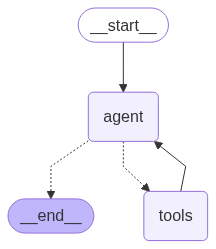

In [17]:
from IPython.display import Image, display

# print graph in image and display it
graph_image = agent.get_graph().draw_mermaid_png()
display(Image(graph_image))

## custom built

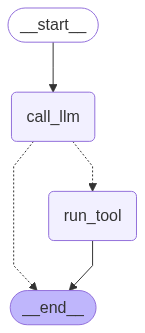

In [23]:
from typing import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_groq import ChatGroq
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

llm = ChatGroq(
  api_key=os.getenv('GROQ_API_KEY'),
  model_name="llama3-8b-8192",
  temperature=0.5,
  max_retries=2
)

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

model_with_tools = llm.bind_tools([write_email])

# NODES
def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""

    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}

def run_tool(state: MessagesState):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
    return {"messages": result}

# EDGES
# conditional edges return the name of the node to go to next
def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:
    """Route to tool handler, or end if Done tool called"""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls:
        return "run_tool"
    # Otherwise, we stop (reply to the user)
    return END

# GRAPH
workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {"run_tool": "run_tool", END: END})
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

# DISPLAY GRAPH
graph_image = app.get_graph().draw_mermaid_png()
display(Image(graph_image))